# Infant Classification

## Import necessary Libraries 

In [1]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import random
from IPython.display import Image
import imutils   
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, classification_report

import keras
import tensorflow.keras as K

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator, array_to_img, img_to_array
# from tensorflow.keras.applications import EfficientNetB1
# from tensorflow.keras.applications import EfficientNetB2
# from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import imutils    

os.environ["CUDA_VISIBLE_DEVICES"] = "1"

Using TensorFlow backend.


## Data Visualization

In [2]:
#specify directory
train_dir = 'D:/Team Batch 3/Deny/Nyoba/Training/'
test_dir = 'D:/Team Batch 3/Deny/Nyoba/Testing/'

In [3]:
#create classes
classes = os.listdir('D:/Team Batch 3/Deny/Nyoba/Training')

In [4]:
classes

['glioma_tumor', 'meningioma_tumor', 'pituitary_tumor']

In [5]:
files_path_dict = {}

for c in classes:
  files_path_dict[c] = list(map(lambda x: train_dir + c + '/' + x, os.listdir(train_dir + c)))

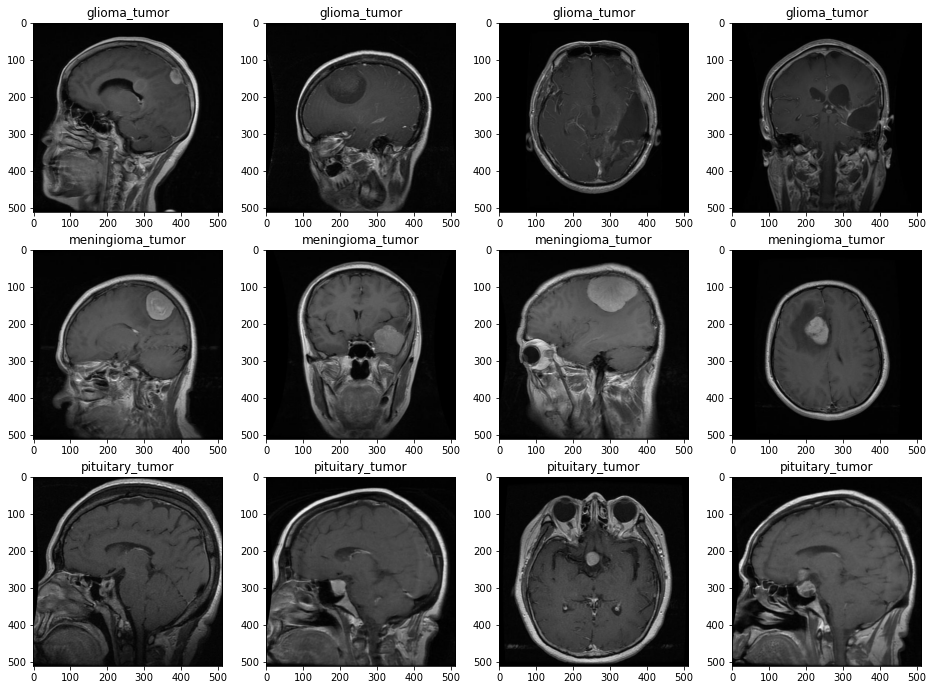

In [6]:
plt.figure(figsize = (16,16))
index = 0
for c in classes:
  random.shuffle(files_path_dict[c])
  path_list = files_path_dict[c][:5]

  for i in range(1, 5):
    index += 1
    plt.subplot(4, 4, index)
    plt.imshow(load_img(path_list[i]))
    plt.title(c)

In [7]:
#check the number of images in each class in the training dataset
No_images_per_class = []
Class_name = []

for i in os.listdir('D:/Team Batch 3/Deny/Nyoba/Training'):
  train_class = os.listdir(os.path.join('D:/Team Batch 3/Deny/Nyoba/Training', i))
  No_images_per_class.append(len(train_class))
  Class_name.append(i)
  print('Number of images in {} = {} \n'.format(i, len(train_class)))

Number of images in glioma_tumor = 826 

Number of images in meningioma_tumor = 822 

Number of images in pituitary_tumor = 827 



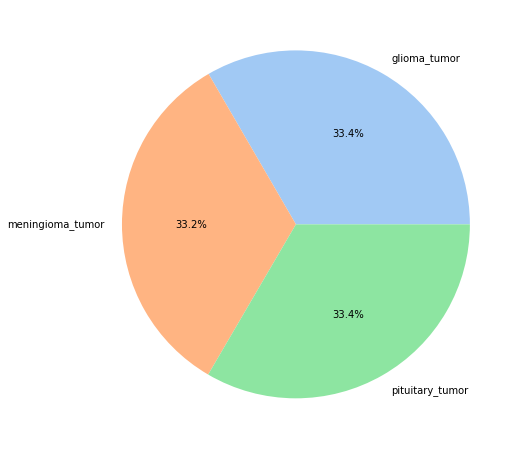

In [8]:
#visualize class distribution in train set
plt.figure(figsize=(8, 8))
colors = sns.color_palette('pastel')
plt.pie(No_images_per_class, 
        labels = Class_name, 
        autopct = '%1.1f%%',
        colors=colors)
plt.show()

## Data Augmentation

In [9]:
#use Image Data Generator to perform this task
#train set
datagen = ImageDataGenerator(rotation_range=10,
                             height_shift_range=0.2,
                             horizontal_flip=True,
                             validation_split=0.2)

train_data = datagen.flow_from_directory('D:/Team Batch 3/Deny/Nyoba/Training/',
                                         target_size=(240, 240),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='training')

valid_data = datagen.flow_from_directory('D:/Team Batch 3/Deny/Nyoba/Training/',
                                         target_size=(240, 240),
                                         batch_size=32,
                                         class_mode='categorical',
                                         subset='validation')

#test set
test_datagen = ImageDataGenerator()

test_data = datagen.flow_from_directory('D:/Team Batch 3/Deny/Nyoba/Training/',
                                         target_size=(240, 240),
                                        class_mode='categorical',
                                        shuffle=False)
                                        

Found 1981 images belonging to 3 classes.
Found 494 images belonging to 3 classes.
Found 2475 images belonging to 3 classes.


In [10]:
#view the class dictionary
print(train_data.class_indices)
print(test_data.class_indices)

{'glioma_tumor': 0, 'meningioma_tumor': 1, 'pituitary_tumor': 2}
{'glioma_tumor': 0, 'meningioma_tumor': 1, 'pituitary_tumor': 2}


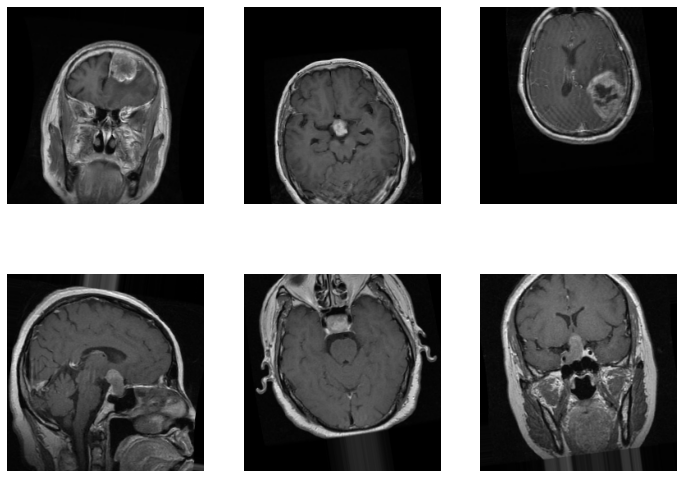

In [11]:
#view the augmented data
sample_x, sample_y = next(train_data)
plt.figure(figsize=(12, 9))
for i in range(6):
  plt.subplot(2, 3, i+1)
  sample = array_to_img(sample_x[i])
  plt.axis('off')
  plt.grid(False)
  plt.imshow(sample)
plt.show()

## Model Architect

In [12]:
#build the model
effnet = ResNet50(weights='imagenet', 
                        include_top=False, 
                        input_shape=None)

model = effnet.output
model = GlobalAveragePooling2D()(model)
model = Dropout(0.5)(model)
model = Dense(3, activation='softmax')(model)
model = Model(inputs=effnet.input, 
              outputs=model)

#get summary()
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

## Compile Model

In [13]:
#compile model
model.compile(optimizer=Adam(lr=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

#define checkpoint
checkpoint = ModelCheckpoint('ResNet50 No Resize.h5', 
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='auto',
                             verbose=1)

#early stopping
earlystop = EarlyStopping(monitor='val_accuracy',
                          patience=5,
                          mode='auto',
                          verbose=1)

#reduce learning rate
reduce_lr = ReduceLROnPlateau(monitor = 'val_accuracy', 
                              factor = 0.3, 
                              patience = 2, 
                              min_delta = 0.001,
                              mode='auto',
                              verbose=1)

## Model Training and Model Evaluation

In [14]:
%%time

#train the model
history = model.fit(train_data,
                    epochs = 30,
                    validation_data=valid_data,
                    verbose=1,
                    callbacks=[checkpoint, earlystop, reduce_lr])

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 62 steps, validate for 16 steps
Epoch 1/30
61/62 [============================>.] - ETA: 0s - loss: 0.3871 - accuracy: 0.8404
Epoch 00001: val_accuracy improved from -inf to 0.50202, saving model to ResNet50 No Resize.h5
62/62 [==============================] - 30s 486ms/step - loss: 0.3840 - accuracy: 0.8415 - val_loss: 2.2793 - val_accuracy: 0.5020
Epoch 2/30
61/62 [============================>.] - ETA: 0s - loss: 0.1367 - accuracy: 0.9554
Epoch 00002: val_accuracy improved from 0.50202 to 0.79757, saving model to ResNet50 No Resize.h5
62/62 [==============================] - 25s 403ms/step - loss: 0.1392 - accuracy: 0.9541 - val_loss: 0.6158 - val_accuracy: 0.7976
Epoch 3/30
61/62 [============================>.] - ETA: 0s - loss: 0.0746 - accuracy: 0.9718
Epoch 00003: val_accuracy improved from 0.79757 to 0.84615, saving model to ResNet50 No Resize.h5
62/62 [==============================] - 25s 404ms/step - loss: 0.0736 

## Model Evaluation

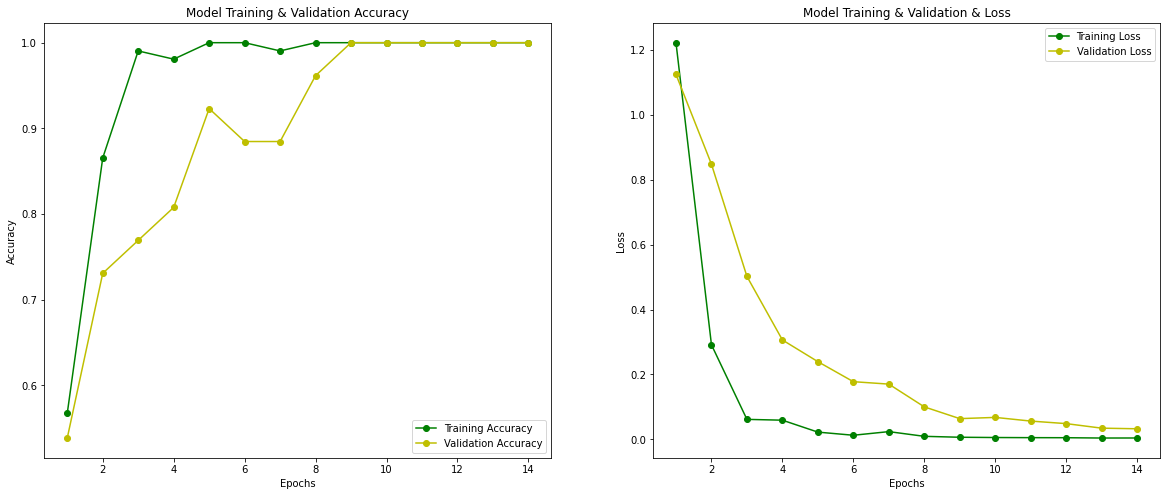

In [23]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

epochs = range(1, len(train_acc) + 1)

ax[0].plot(epochs , train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('Model Training & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('Model Training & Validation & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")

plt.show()

In [24]:
print('Train accuracy & loss:', model.evaluate(train_data))
print('\n')
print('Test accuracy & loss:', model.evaluate(test_data))

  ...
    to  
  ['...']
4/4 [==============================] - 2s 511ms/step - loss: 0.0160 - accuracy: 1.0000
Train accuracy & loss: [0.016008693433832377, 1.0]


  ...
    to  
  ['...']
5/5 [==============================] - 4s 824ms/step - loss: 0.0180 - accuracy: 1.0000
Test accuracy & loss: [0.01803009925497463, 1.0]


In [15]:
#define labels for testing
y_test = test_data.classes

#make prediction
yhat_test = np.argmax(model.predict(test_data), axis=1)

In [24]:
y_test

array([0, 0, 0, ..., 2, 2, 2])

In [26]:
yhat_test

array([0, 0, 0, ..., 2, 2, 2], dtype=int64)

In [16]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

[[823   1   2]
 [  5 802  15]
 [  0   7 820]]


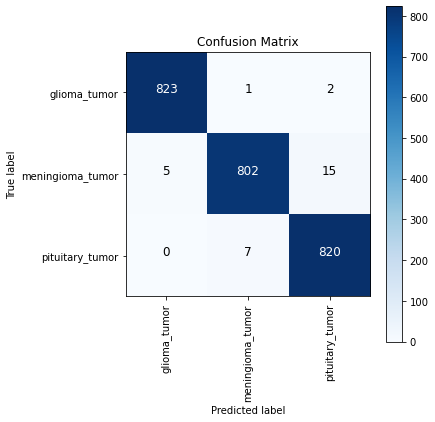

In [17]:
#get confusion matrix
cm = confusion_matrix(y_test, yhat_test)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)

In [18]:
#get classification report
print(classification_report(y_test, yhat_test))

              precision    recall  f1-score   support

           0       0.99      1.00      1.00       826
           1       0.99      0.98      0.98       822
           2       0.98      0.99      0.99       827

    accuracy                           0.99      2475
   macro avg       0.99      0.99      0.99      2475
weighted avg       0.99      0.99      0.99      2475



## Obtaining Predictions on Test Images

In [36]:
import PIL

class_dict = {0: 'no',
              1: 'yes'}
              
prediction = []
original = []
image = []
count = 0
for i in os.listdir('D:/Team Batch 3/Deny/Nyoba/Data 2 Class/'):
  for item in os.listdir(os.path.join('D:/Team Batch 3/Deny/Nyoba/Data 2 Class', i)):
    # code to open the image
    img= PIL.Image.open(os.path.join('D:/Team Batch 3/Deny/Nyoba/Data 2 Class', i, item))
    #append to image list
    image.append(img)
    #expand dimension
    img = np.expand_dims(img, axis=0)
    #predict
    predict = model.predict(img)
    #get the index corresponding to the highest value in the prediction
    predict = np.argmax(predict)
    #append the predicted class to the list
    prediction.append(class_dict[predict])
    #append original class to the list
    original.append(i)

In [38]:
#test accuracy 
score = accuracy_score(original, prediction)
print("Test Accuracy : {}".format(score))

Test Accuracy : 0.4311111111111111


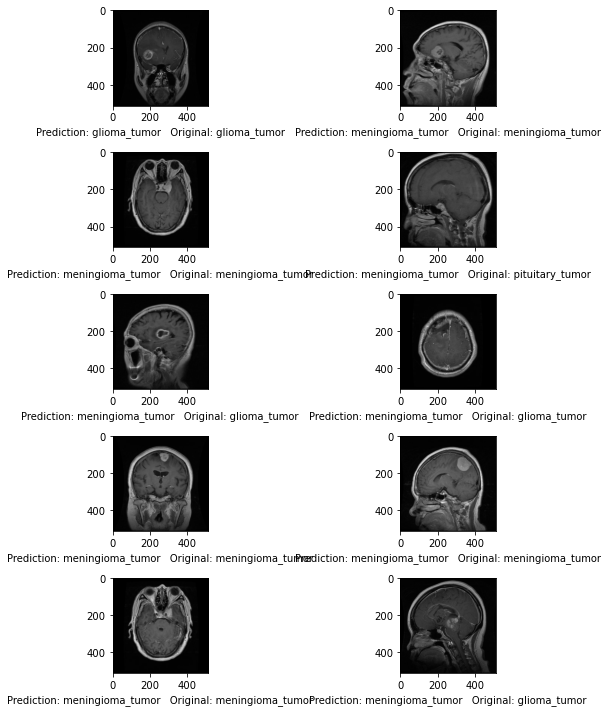

In [39]:
#visualize the results
fig = plt.figure(figsize = (10, 10))
for i in range(10):
    j = random.randint(0, len(image))
    fig.add_subplot(5, 2, i+1)
    plt.xlabel("Prediction: " + prediction[j] +"   Original: " + original[j])
    plt.imshow(image[j])
fig.tight_layout()
plt.show()